```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is a prototype for all required parts of a realistic simulation

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from IPython.display import display

from matplotlib import pyplot as plt
#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization

import norkyst_plotting

In [3]:
%setup_logging -o lofoten_sim.log
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger disabled
Python version 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Registering gpu_ctx in user workspace
PyCUDA version 2019.1.2
CUDA version (10, 1, 0)
Driver version 10010
Using 'Tesla P100-PCIE-12GB' GPU
Created context handle <94057957127184>


# Select area and result folder

In [4]:
#Set this to false before comitting to only get images
download_data = True

#Which timesteps to simulate
timestep_indices = None

#Arguments for plotting
plotting_kwargs = {
     'h_max':  0.9, 
     'h_min': -0.9, 
     'uv_max':  75, 
     'uv_min': -75, 
     'movie_frames': 200, 
     'create_movie': False,
     'add_extra': 2,
     'rotate': False
}
#Figure size - larger=slower
plotting_figsize = (16, 8)

#Downsampling of plotting - larger=faster, None = no downsampling
downsample = None

# Parameter to control the frequency of writing to NetCDF. Given in number of entries per hour
netcdf_frequency = 1

#Plot only interior domain
#Note: This also removes sponge cells
interior_domain_only = True

#Number of spong cells (north, east, south, west)
sponge_cells = {'north':20, 'south': 20, 'east': 20, 'west': 20}

# How many cells to erode of land
erode_land=0

cases = [
    {'name': 'norwegian_sea',  'x0':  900, 'x1': 1400, 'y0':  600, 'y1':  875 },
    {'name': 'lofoten',        'x0': 1400, 'x1': 1900, 'y0':  450, 'y1':  750 },
    {'name': 'lofoten_close',  'x0': 1650, 'x1': 1800, 'y0':  500, 'y1':  600 },
    {'name': 'complete_coast', 'x0':   25, 'x1': 2575, 'y0':   25, 'y1':  875 },
    {'name': 'skagerak',       'x0':  300, 'x1':  600, 'y0':   50, 'y1':  250 },
    {'name': 'oslo',           'x0':  430, 'x1':  570, 'y0':  100, 'y1':  230 }
]
case = cases[1]
out_folder = os.path.join(datetime.date.today().isoformat(), case['name'])

os.makedirs(out_folder, exist_ok=True)
print("Output will be placed in '" + out_folder + "'")

Output will be placed in '2019-11-29/lofoten'


# Inspect URL and select area

In [5]:
nordic4km_url = 'http://thredds.met.no/thredds/dodsC/fou-hi/nordic4km-1h/Nordic-4km_SURF_1h_avg_00.nc'
norkyst800_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

source_url = norkyst800_url

In [6]:
if (download_data):
    filename = os.path.abspath(os.path.basename(source_url))
    cache_folder='netcdf_cache'
    cache_filename = os.path.abspath(os.path.join(cache_folder,
                                                  os.path.basename(source_url)))
    
    if (os.path.isfile(filename)):
        source_url = filename
        
    elif (os.path.isfile(cache_filename)):
        source_url = cache_filename
    
    else:
        import requests
        download_url = source_url.replace("dodsC", "fileServer")

        req = requests.get(download_url, stream = True)
        filesize = int(req.headers.get('content-length'))

        progress = Common.ProgressPrinter()
        pp = display(progress.getPrintString(0),display_id=True)

        print("Downloading data to local file (" + str(filesize // (1024*1024)) + " MB)")
        with open(filename, "wb") as outfile:
            for chunk in req.iter_content(chunk_size = 10*1024*1024):
                if chunk:
                    outfile.write(chunk)
                    pp.update(progress.getPrintString(outfile.tell() / filesize))

        source_url = filename
        
print("Source is : " + source_url)

Source is : /home/andreb/projects/gpu-ocean/gpu_ocean/demos/realisticSimulations/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc


# Helpers for plotting and running simulation

In [7]:
def ncSimulation(sim, filename, timesteps, interior_domain_only, num_substeps=3):
    if (os.path.isfile(filename)):
        print("File " + filename + " already exists, skipping simulation.")
        return
    
    try:
        ncfile = Dataset(filename, 'w')
        
        #the order of spongecells is misleading at best
        scn = sim.boundary_conditions.spongeCells['north']
        sce = sim.boundary_conditions.spongeCells['east']
        scs = sim.boundary_conditions.spongeCells['south']
        scw = sim.boundary_conditions.spongeCells['west']
        
        def removeGhosts(var):
            if (interior_domain_only):
                #FIXME: Not sure if this is right.
                #also, what is the order of the numpy array, and where is 0,0?
                #for symmetric sponge cells this does not matter.
                return var[scw:-sce, scn:-scs]
            else:
                return var

        var = {}
        var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=interior_domain_only)
        _, var['Hm'] = sim.downloadBathymetry(interior_domain_only=interior_domain_only)

        ny, nx = var['eta'].shape
        if (interior_domain_only):
            nx = nx-sce-scw
            ny = ny-scn-scs

        # Create dimensions
        ncfile.createDimension('time', None) # unlimited
        ncfile.createDimension('x', nx)
        ncfile.createDimension('y', ny)

        ncvar = {}

        # Create variables for dimensions
        ncvar['time'] = ncfile.createVariable('time', 'f8', ('time',))
        ncvar['x'] = ncfile.createVariable('x', 'f4', ('x',))
        ncvar['y'] = ncfile.createVariable('y', 'f4', ('y',))

        # Fill dimension variables
        ncvar['x'][:] = np.linspace(0, nx*sim.dx, nx)
        ncvar['y'][:] = np.linspace(0, ny*sim.dy, ny)

        # Create static variables
        ncvar['Hm'] = ncfile.createVariable('Hm', 'f8', ('y', 'x',), zlib=True)
        ncvar['Hm'][:,:] = removeGhosts(var['Hm'][:,:])

        # Create time varying data variables
        for varname in ['eta', 'hu', 'hv']:
            ncvar[varname] = ncfile.createVariable(varname, 'f8', ('time', 'y', 'x',), zlib=True)
        ncvar['num_iterations'] = ncfile.createVariable('num_iterations', 'i4', ('time',))

        #Simulate n timesteps
        timestep_sizes = timesteps[1:] - timesteps[:-1]        
        timestep_sizes = np.insert(timestep_sizes, 0, 0)

        progress = Common.ProgressPrinter(5)
        pp = display(progress.getPrintString(0), display_id=True)
        for i, timestep_size in enumerate(timestep_sizes):
            #Don't simulate if first step (store initial conditions also)
            if (timestep_size > 0):
                substep_size = timestep_size / num_substeps
                for j in range(num_substeps):
                    sim.updateDt()
                    sim.step(substep_size)

            var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=interior_domain_only)
            ncvar['time'][i] = sim.t
            ncvar['num_iterations'][i] = sim.num_iterations

            abort=False
            for varname in ['eta', 'hu', 'hv']:
                ncvar[varname][i,:,:] = removeGhosts(var[varname][:,:]) #np.ma.masked_invalid(var[varname][:,:])
                if (np.any(np.isnan(var[varname]))):
                    print("Variable " + varname + " contains NaN values!")
                    abort=True

            if (abort):
                print("Aborting at t=" + str(sim.t))
                ncfile.sync()
                break

            pp.update(progress.getPrintString(i/(len(timestep_sizes)-1)))

    except Exception as e:
        print("Something went wrong:" + str(e))
        raise e
    finally:
        ncfile.close()

# Plot reference solution

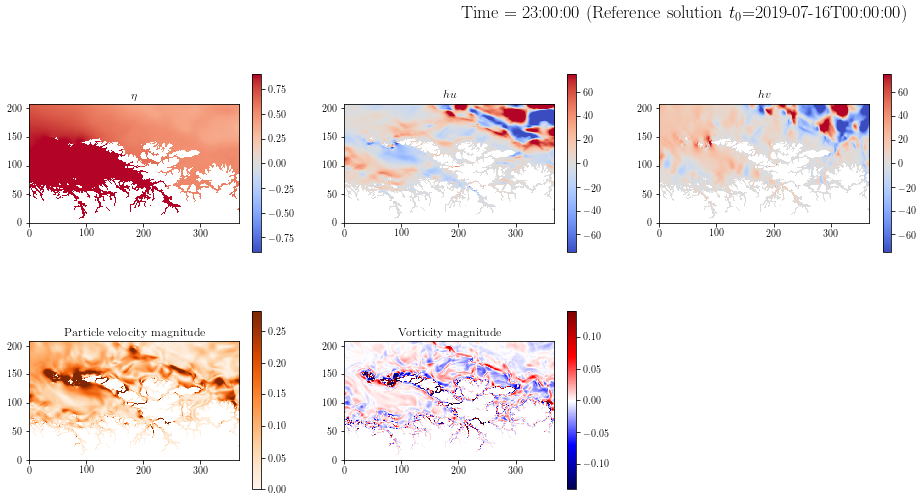

In [8]:
extent = case.copy()
if (interior_domain_only):
    extent['x0'] += sponge_cells['west']
    extent['x1'] -= sponge_cells['east']
    extent['y0'] += sponge_cells['south']
    extent['y1'] -= sponge_cells['north']

fig = plt.figure(figsize=plotting_figsize)
norkyst_plotting.refAnimation(source_url, extent,
             timestep_indices=timestep_indices,
             fig=fig, 
             downsample=downsample,
             **plotting_kwargs)

# Run original resolution simulation

In [9]:
# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "rk_order": 2,
    "desingularization_eps": 1.0
}

In [10]:
data_args = NetCDFInitialization.getInitialConditions(source_url, case['x0'], case['x1'], case['y0'], case['y1'], 
                                                      timestep_indices=timestep_indices,
                                                      erode_land=erode_land, 
                                                      sponge_cells=sponge_cells)

#Add substeps for netcdf
if netcdf_frequency > 1:    
    n_timesteps = len(data_args['timesteps'])
    x = np.linspace(0, 1, n_timesteps)
    y = data_args['timesteps']
    x_interp = np.linspace(0, 1, n_timesteps*netcdf_frequency)
    y_interp = np.interp(x_interp, x, y)
    data_args['timesteps'] = y_interp

importlib.reload(CDKLM16)
sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))

original_filename = os.path.join(out_folder, case['name'] + "_original.nc")
ncSimulation(sim=sim, 
             filename=original_filename,
             timesteps=data_args['timesteps'],
             interior_domain_only=interior_domain_only)

Subsampling angle texture by factor 10
This will give inaccurate angle along the border!
Subsampling coriolis texture by factor 10
This will give inaccurate coriolis along the border!


File 2019-11-29/lofoten/lofoten_original.nc already exists, skipping simulation.


'0% [==============================] 100%. Total: nan, elapsed: 0s, remaining: nan'

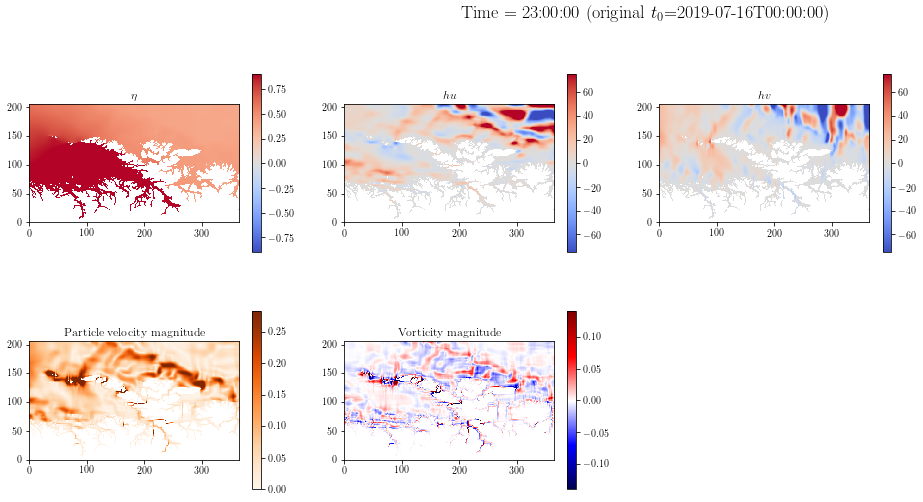

In [11]:
fig = plt.figure(figsize=plotting_figsize)
norkyst_plotting.ncAnimation(original_filename,
             title="original $t_0$=" + datetime.datetime.fromtimestamp(data_args['t0']).isoformat(timespec='seconds'),
             fig=fig,
             downsample=downsample,
             **plotting_kwargs)

# Simulate low-resolution

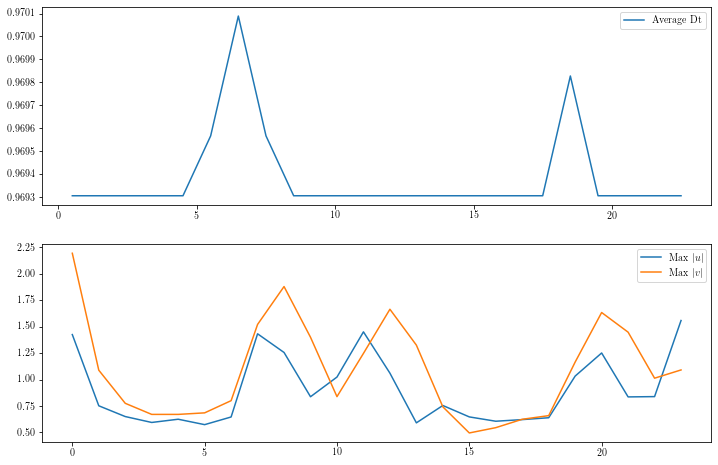

In [12]:
plt.figure(figsize=(12,8))
norkyst_plotting.plotStatistics(original_filename)

In [13]:
data_args_lowres = NetCDFInitialization.rescaleInitialConditions(data_args, scale=0.5)

importlib.reload(CDKLM16)
sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args_lowres))

lowres_filename = os.path.join(out_folder, case['name'] + "_lowres.nc")
ncSimulation(sim=sim, 
             filename=lowres_filename,
             timesteps=data_args['timesteps'],
             interior_domain_only=interior_domain_only)

Subsampling angle texture by factor 10
This will give inaccurate angle along the border!
Subsampling coriolis texture by factor 10
This will give inaccurate coriolis along the border!


File 2019-11-29/lofoten/lofoten_lowres.nc already exists, skipping simulation.


'0% [==============================] 100%. Total: nan, elapsed: 0s, remaining: nan'

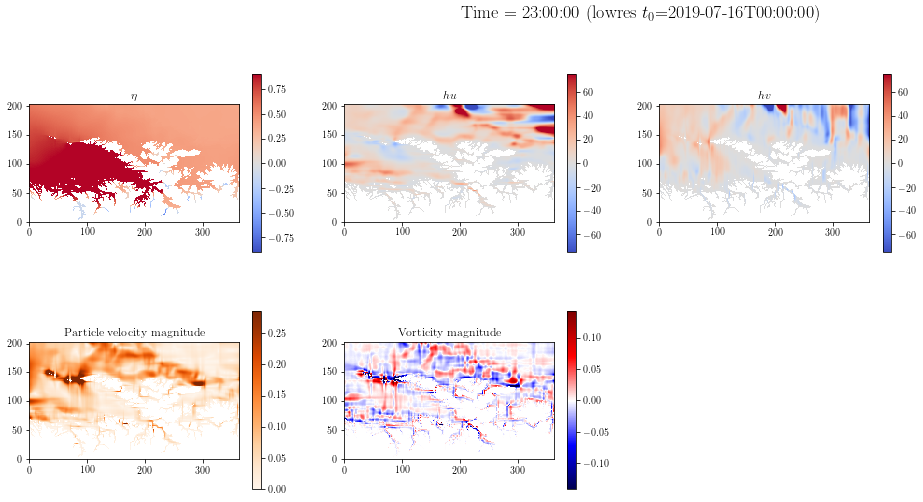

In [14]:
fig = plt.figure(figsize=plotting_figsize)
downsample_lowres = downsample
if (downsample_lowres is not None):
    downsample_lowres = downsample_lowres//2
    
norkyst_plotting.ncAnimation(lowres_filename, 
             title="lowres $t_0$=" + datetime.datetime.fromtimestamp(data_args['t0']).isoformat(timespec='seconds'),
             fig=fig,
             downsample=downsample_lowres,
             **plotting_kwargs)

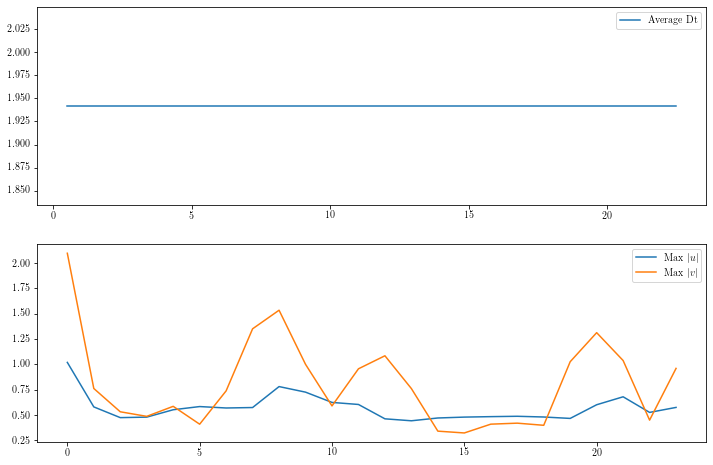

In [15]:
plt.figure(figsize=(12,8))
norkyst_plotting.plotStatistics(lowres_filename)

# Simulate high-resolution

In [16]:
data_args_highres = NetCDFInitialization.rescaleInitialConditions(data_args, scale=2)

importlib.reload(CDKLM16)
sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args_highres))

highres_filename = os.path.join(out_folder, case['name'] + "_highres.nc")
ncSimulation(sim=sim, 
             filename=highres_filename,
             timesteps=data_args['timesteps'],
             interior_domain_only=interior_domain_only)

Subsampling angle texture by factor 10
This will give inaccurate angle along the border!
Subsampling coriolis texture by factor 10
This will give inaccurate coriolis along the border!


File 2019-11-29/lofoten/lofoten_highres.nc already exists, skipping simulation.


'0% [==============================] 100%. Total: nan, elapsed: 0s, remaining: nan'

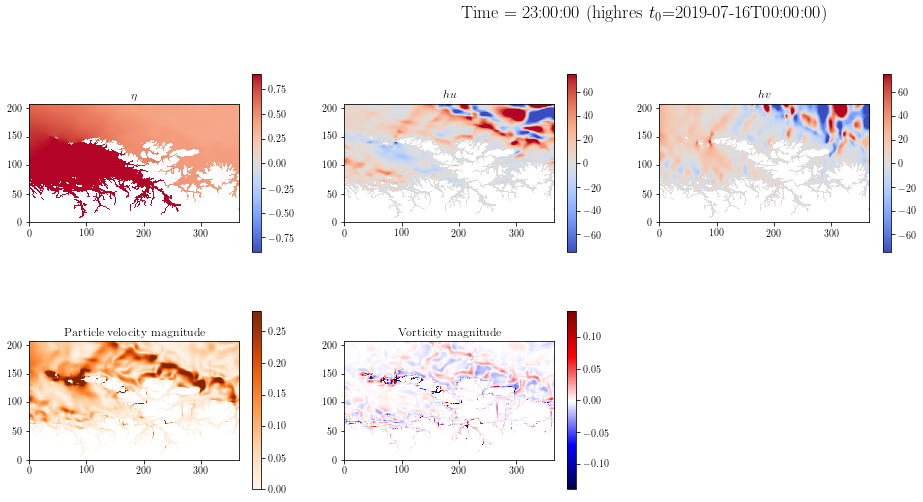

In [17]:
fig = plt.figure(figsize=plotting_figsize)
downsample_highres = downsample
if (downsample_highres is not None):
    downsample_highres = downsample_highres*2
    
norkyst_plotting.ncAnimation(highres_filename, 
             title="highres $t_0$=" + datetime.datetime.fromtimestamp(data_args['t0']).isoformat(timespec='seconds'),
             fig=fig,
             downsample=downsample_highres,
             **plotting_kwargs)

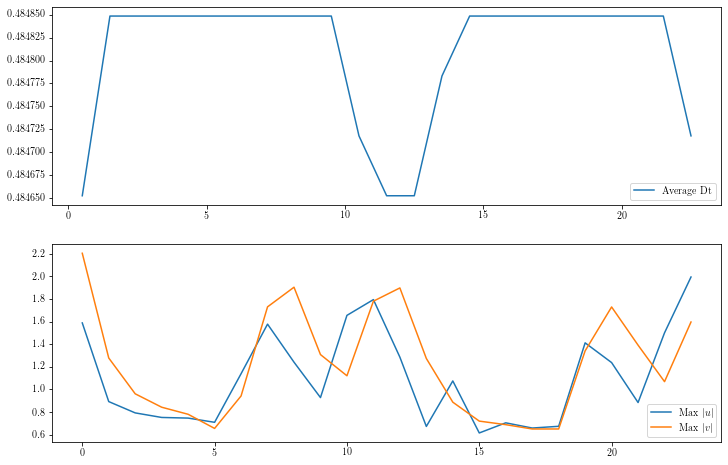

In [18]:
plt.figure(figsize=(12,8))
norkyst_plotting.plotStatistics(highres_filename)

In [19]:
print(sim.boundary_conditions)

north: Flow Relaxation Scheme, east: Flow Relaxation Scheme, south: Flow Relaxation Scheme, west: Flow Relaxation Scheme, spongeCells: {'north': 40, 'south': 40, 'east': 40, 'west': 40}
